In [1]:
import model_training_improved as mti
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak

In [2]:
def read_arrays(file_path):
    """
    Read arrays from a ROOT file.
    """
    import uproot as r
    f = r.open(file_path)
    tree = f["Delphes"]

    # read jet features as variable-length arrays (padded with zeros)
    jet_pt = ak.fill_none(ak.pad_none(tree["Jet.PT"].array(), 4, axis=1), 0)
    jet_eta = ak.fill_none(ak.pad_none(tree["Jet.Eta"].array(), 4, axis=1), 0)
    jet_phi = ak.fill_none(ak.pad_none(tree["Jet.Phi"].array(), 4, axis=1), 0)
    jet_mass = ak.fill_none(ak.pad_none(tree["Jet.Mass"].array(), 4, axis=1), 0)

    # build jet features as a dataframe
    df = pd.DataFrame({
        "jet_pt1": jet_pt[:, 0],
        "jet_eta1": jet_eta[:, 0],
        "jet_phi1": jet_phi[:, 0],
        "jet_mass1": jet_mass[:, 0],
        "jet_pt2": jet_pt[:, 1],
        "jet_eta2": jet_eta[:, 1],
        "jet_phi2": jet_phi[:, 1],
        "jet_mass2": jet_mass[:, 1],
        # "jet_pt3": jet_pt[:, 2],
        # "jet_eta3": jet_eta[:, 2],
        # "jet_phi3": jet_phi[:, 2],
        # 'jet_mass3': jet_mass[:, 2],
    })
    # build other jet variables
    df["jet_deta12"] = abs(df["jet_eta1"] - df["jet_eta2"])
    df['jet_dphi12'] = (df['jet_phi1'] - df['jet_phi2']) % (2 * np.pi)  # constrain to [0, 2pi]

    # 新的变量
    
    # 计算新物理变量
    df['jet_E1'] = np.sqrt(df['jet_pt1']**2 * np.cosh(df['jet_eta1'])**2 + df['jet_mass1']**2)
    df['jet_E2'] = np.sqrt(df['jet_pt2']**2 * np.cosh(df['jet_eta2'])**2 + df['jet_mass2']**2)
    # 喷注对不变量质量
    df['jet_inv_mass'] = np.sqrt((df['jet_E1'] + df['jet_E2'])**2 - 
                                (df['jet_pt1']*np.sinh(df['jet_eta1']) + df['jet_pt2']*np.sinh(df['jet_eta2']))**2 - 
                                (df['jet_pt1']*np.cos(df['jet_phi1']) + df['jet_pt2']*np.cos(df['jet_phi2']))**2)
    # 角度差
    df['jet_dR12'] = np.sqrt((df['jet_eta1'] - df['jet_eta2'])**2 + 
                            (df['jet_phi1'] - df['jet_phi2'])**2)
    # 横向动量不对称性
    df['jet_aT'] = np.abs(df['jet_pt1'] - df['jet_pt2']) / (df['jet_pt1'] + df['jet_pt2'])

    return df

In [3]:
"""
这是一个处理物理分析数据的代码片段，主要用于读取不同能量下的Z'粒子数据和多重 jets 背景数据，
并为每个数据样本分配标签以便后续的分类分析。
"""
file_list = [
    './data/delphes_zprime_1TeV.root',
    './data/delphes_zprime_1p5TeV.root',
    './data/delphes_zprime_2TeV.root',
    './data/delphes_zprime_2p5TeV.root',
    './data/delphes_multijet.root',
]

df_list = []  # 用于存储读取的数据框的列表
for i, file in enumerate(file_list):
    df_list.append(read_arrays(file))  # Read features from ROOT file and append to list
    if 'zprime_1TeV' in file:  # Assign integer label to each sample for classification
        df_list[i]['label'] = 1
    elif 'zprime_1p5TeV' in file:
        df_list[i]['label'] = 2
    elif 'zprime_2TeV' in file:
        df_list[i]['label'] = 3
    elif 'zprime_2p5TeV' in file:
        df_list[i]['label'] = 4
    elif 'multijet' in file:
        df_list[i]['label'] = 0  # background

    # a variable used as training label: (signal: 1, background: 0)
    df_list[i]['label_is_sig'] = (df_list[i]['label'] > 0).astype(int)

df = pd.concat(df_list, axis=0)  # Concatenate all DataFrames into a single DataFrame for analysis
df


,jet_pt1,jet_eta1,jet_phi1,jet_mass1,jet_pt2,jet_eta2,jet_phi2,jet_mass2,jet_deta12,jet_dphi12,jet_E1,jet_E2,jet_inv_mass,jet_dR12,jet_aT,label,label_is_sig
0,431.166626,-0.409789,-0.053466,16.269297,409.961182,0.653760,3.079527,16.136507,1.063549,3.150192,468.161176,500.995320,963.121978,3.308592,0.025211,1,1
1,281.611206,-0.309674,0.142321,5.474829,266.998352,1.263712,-2.993311,9.688689,1.573386,3.135632,295.273207,510.210322,727.209284,3.508238,0.026636,1,1
2,430.977814,0.712181,1.090687,12.586125,404.504059,-0.164918,-2.051517,12.297118,0.877099,3.142204,545.117942,410.201726,917.306488,3.262322,0.031687,1,1
3,540.412903,0.508327,1.826380,17.101940,400.870605,0.364258,-1.318158,13.366835,0.144070,3.144537,611.988838,427.969272,943.463661,3.147836,0.148247,1,1
4,221.092957,-0.547750,-1.200881,2.974811,215.453430,2.328024,1.938679,9.611918,2.875774,3.143626,255.115208,1115.566850,971.159916,4.257571,0.012919,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,113.362823,-0.791257,0.909017,5.877603,90.417923,-2.293667,-2.210016,6.940484,1.502410,3.119033,150.855485,452.690504,263.271102,3.462023,0.112596,0,0
99996,156.986099,1.158455,0.568787,16.566175,111.824272,2.234097,-2.614952,7.807077,1.075643,3.183739,275.144638,528.155479,306.973547,3.360536,0.168006,0,0
99997,126.222260,2.718263,-3.091912,4.411303,123.380188,0.561036,0.059249,9.470507,2.157227,3.132025,960.559533,143.625162,410.273456,3.818827,0.011386,0,0
99998,108.420639,1.886348,3.070095,6.271837,92.195427,0.425001,-0.089519,9.848572,1.461346,3.159614,365.803268,101.128673,256.721183,3.481191,0.080877,0,0


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


PyTorch版本: 2.7.1+cpu
CUDA是否可用: False
未检测到GPU设备 使用CPU
目标列类别分布:
label_is_sig
1    0.666667
0    0.333333
Name: proportion, dtype: float64
检查数据中的NaN值...
警告: 输入数据中包含NaN值，将替换为0
标准化数据...
检查类别不平衡...
目标列包含两个类别，将使用分层抽样
数据预处理完成
目标列类别分布:
label_is_sig
1    0.666667
0    0.333333
Name: proportion, dtype: float64
处理前数据形状: (300000, 30)
包含NaN值的列: []
训练集大小: 240000
验证集大小: 30000
测试集大小: 30000


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


开始训练模型...



   | Name      | Type               | Params | Mode 
----------------------------------------------------------
0  | layer1    | Linear             | 1.8 K  | train
1  | bn1       | BatchNorm1d        | 256    | train
2  | dropout1  | Dropout            | 0      | train
3  | layer2    | Linear             | 16.5 K | train
4  | bn2       | BatchNorm1d        | 256    | train
5  | dropout2  | Dropout            | 0      | train
6  | layer3    | Linear             | 8.3 K  | train
7  | bn3       | BatchNorm1d        | 128    | train
8  | dropout3  | Dropout            | 0      | train
9  | layer4    | Linear             | 130    | train
10 | train_acc | MulticlassAccuracy | 0      | train
11 | val_acc   | MulticlassAccuracy | 0      | train
----------------------------------------------------------
27.3 K    Trainable params
0         Non-trainable params
27.3 K    Total params
0.109     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

保存模型到: ./tb_logs/improved_model/16-56.ckpt
在测试集上评估模型...

分类报告:
              precision    recall  f1-score   support

  Background       0.97      0.96      0.97     10000
      Signal       0.98      0.99      0.98     20000

    accuracy                           0.98     30000
   macro avg       0.98      0.98      0.98     30000
weighted avg       0.98      0.98      0.98     30000

测试集AUC: 0.9979


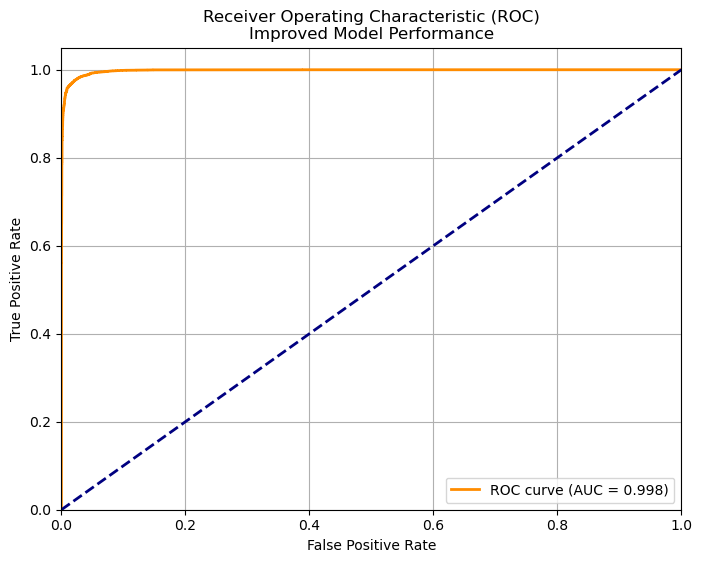

训练完成，测试集AUC: 0.9979


In [4]:
# 使用已经定义的df数据框架(而不是未定义的df1)
# 确保input_columns和target_column已经定义

# 如果尚未定义，可以定义如下：
input_columns = ['jet_pt1', 'jet_eta1', 'jet_phi1', 'jet_mass1', 'jet_pt2', 
                'jet_eta2', 'jet_phi2', 'jet_mass2', 'jet_deta12', 'jet_dphi12',
                'jet_inv_mass', 'jet_dR12', 'jet_aT']
target_column = 'label_is_sig'

# 定义模型保存路径
model_path = "./tb_logs/improved_model/16-56.ckpt"

# 调用改进的训练函数
model, auc = mti.train_model(
    df=df,  # 使用已经定义好的df，而不是df1
    input_columns=input_columns,
    target_column=target_column,
    model_path=model_path,
    max_epochs=50,
    batch_size=128
)

print(f"训练完成，测试集AUC: {auc:.4f}")


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


PyTorch版本: 2.7.1+cpu
CUDA是否可用: False
未检测到GPU设备 使用CPU
目标列类别分布:
label_is_sig
1    0.666667
0    0.333333
Name: proportion, dtype: float64
检查数据中的NaN值...
警告: 输入数据中包含NaN值，将替换为0
标准化数据...
检查类别不平衡...
目标列包含两个类别，将使用分层抽样
数据预处理完成
处理前数据形状: (300000, 30)
包含NaN值的列: []
训练集大小: 240000
验证集大小: 30000
测试集大小: 30000



   | Name      | Type               | Params | Mode 
----------------------------------------------------------
0  | layer1    | Linear             | 1.8 K  | train
1  | bn1       | BatchNorm1d        | 256    | train
2  | dropout1  | Dropout            | 0      | train
3  | layer2    | Linear             | 16.5 K | train
4  | bn2       | BatchNorm1d        | 256    | train
5  | dropout2  | Dropout            | 0      | train
6  | layer3    | Linear             | 8.3 K  | train
7  | bn3       | BatchNorm1d        | 128    | train
8  | dropout3  | Dropout            | 0      | train
9  | layer4    | Linear             | 130    | train
10 | train_acc | MulticlassAccuracy | 0      | train
11 | val_acc   | MulticlassAccuracy | 0      | train
----------------------------------------------------------
27.3 K    Trainable params
0         Non-trainable params
27.3 K    Total params
0.109     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode

开始训练模型...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

e:\anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:198: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

保存模型到: ./tb_logs/improved_model/19-15_cos.ckpt
在测试集上评估模型...
分类报告:
              precision    recall  f1-score   support

  Background       0.97      0.97      0.97     10000
      Signal       0.98      0.98      0.98     20000

    accuracy                           0.98     30000
   macro avg       0.98      0.98      0.98     30000
weighted avg       0.98      0.98      0.98     30000

测试集AUC: 0.9979


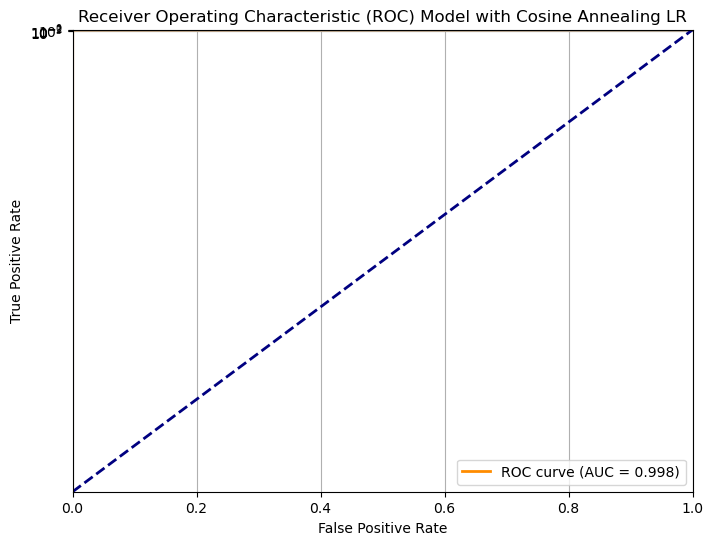

训练完成，测试集AUC: 0.9979


In [27]:
# 使用已经定义的df数据框架(而不是未定义的df1)
# 确保input_columns和target_column已经定义

# 如果尚未定义，可以定义如下：
input_columns = ['jet_pt1', 'jet_eta1', 'jet_phi1', 'jet_mass1', 'jet_pt2', 
                'jet_eta2', 'jet_phi2', 'jet_mass2', 'jet_deta12', 'jet_dphi12',
                'jet_inv_mass', 'jet_dR12', 'jet_aT']
target_column = 'label_is_sig'

# 定义模型保存路径
model_path = "./tb_logs/improved_model/19-15_cos.ckpt"

# 调用改进的训练函数
import model_training_cosine_annealing as mtca

# 调用改进的训练函数
model, auc = mtca.train_model(
    df=df,  # 使用已经定义好的df，而不是df1
    input_columns=input_columns,
    target_column=target_column,
    model_path=model_path,
    max_epochs=50,
    batch_size=128
)

print(f"训练完成，测试集AUC: {auc:.4f}")


目标列类别分布:
label_is_sig
1    0.666667
0    0.333333
Name: proportion, dtype: float64
检查数据中的NaN值...
警告: 输入数据中包含NaN值，将替换为0
标准化数据...
检查类别不平衡...
目标列包含两个类别，将使用分层抽样
数据预处理完成


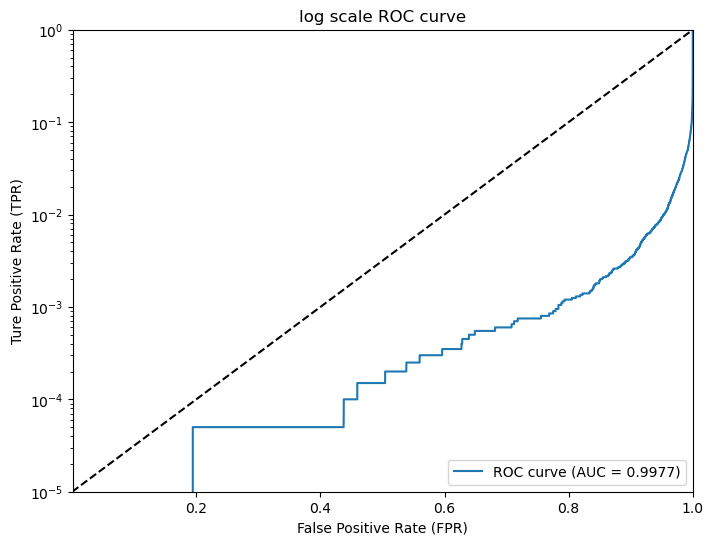

In [17]:

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import model_training_improved as mti
import torch.nn.functional as F

# 假设您已经有了以下变量:
# df: 完整数据集
# input_columns: 输入特征列名列表
# target_column: 目标列名
# model_path: 模型路径

# 数据预处理
df_processed = mti.preprocess_data(df, input_columns, target_column)
trans_columns = [c + '_trans' for c in input_columns]

# 分割数据集
_, test_df = train_test_split(
    df_processed,
    test_size=0.2,
    random_state=42,
    stratify=df_processed[target_column]
)

# 创建测试集数据集
test_dataset = mti.DataFrameDataset(test_df, trans_columns, target_column)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# 加载训练好的模型
model_path = "./tb_logs/improved_model/16-56.ckpt"  # 使用您实际的模型路径
model = mti.ImprovedMLP(input_size=len(input_columns), hidden_size=128, output_size=2)

# 加载模型权重
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

# 使用测试集进行预测
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        pos_probs = probs[:, 1].numpy()
        all_labels.extend(labels.numpy())
        all_probs.extend(pos_probs)

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# 计算ROC曲线
fpr_z, tpr_z, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr_z, tpr_z)

# 绘制对数刻度的ROC曲线
plt.figure(figsize=(8, 6))
plt.semilogy(fpr_z, tpr_z, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([1e-5, 1], [1e-5, 1], 'k--')  # 对角线
plt.xlim([0.001, 1.0])  # 设置x轴范围，避免0值
plt.ylim([1e-5, 1.0])  # 设置y轴范围，避免0值
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('Ture Positive Rate (TPR)')
plt.title('log scale ROC curve')
plt.legend(loc='lower right')
# plt.grid(True, which="both", ls="--")
plt.show()


目标列类别分布:
label_is_sig
1    0.666667
0    0.333333
Name: proportion, dtype: float64
检查数据中的NaN值...
警告: 输入数据中包含NaN值，将替换为0
标准化数据...
检查类别不平衡...
目标列包含两个类别，将使用分层抽样
数据预处理完成
模型 4L simple cos_anl 的输入特征大小: 13
成功加载模型 4L simple cos_anl
模型 3L 的输入特征大小: 10
成功加载模型 3L
模型 4L cos_anl 的输入特征大小: 13
成功加载模型 4L cos_anl
模型 3L simple cos_anl 的输入特征大小: 10
成功加载模型 3L simple cos_anl


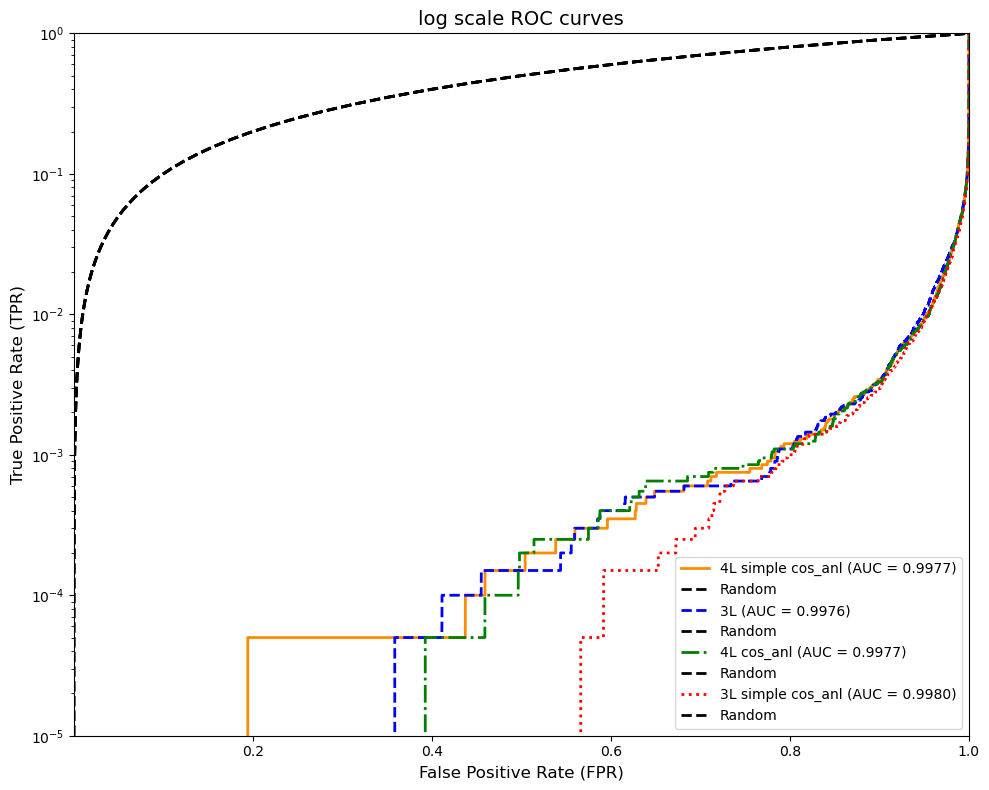

In [38]:

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import model_training_improved as mti
import torch.nn.functional as F
import pytorch_lightning as L
from torch import nn
import torchmetrics
import os

# 定义基础MLP模型类
class SimpleMLP(L.LightningModule):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleMLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)   # 第一层全连接层
        self.layer2 = nn.Linear(hidden_size, hidden_size)  # 第二层全连接层
        self.layer3 = nn.Linear(hidden_size, output_size)  # 输出层

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=output_size)  # 训练准确率指标
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=output_size)    # 验证准确率指标

    def forward(self, x):
        # 前向传播：输入 -> relu -> 隐藏层 -> relu -> 输出
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

    def training_step(self, batch, batch_idx):
        # 定义每个训练批次的操作
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.train_acc(logits, y)
        # 记录训练损失和准确率
        self.log('train_loss', loss)
        self.log('train_acc', self.train_acc, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # 定义每个验证批次的操作
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.val_acc(logits, y)
        # 记录验证损失和准确率
        self.log('val_loss', loss)
        self.log('val_acc', self.val_acc, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        # 设置优化器和学习率调度器
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

# 假设您已经有了以下变量:
# df: 完整数据集
# input_columns: 输入特征列名列表
# target_column: 目标列名

# 定义模型列表，每个模型包含名称、路径和线条样式
models_info = [
    {
        "name": "4L simple cos_anl",
        "path": "./tb_logs/improved_model/16-56.ckpt",
        "color": "darkorange",
        "linestyle": "-",
        "model_class": mti.ImprovedMLP,
        "model_args": {"hidden_size": 128, "output_size": 2}
    },
    {
        "name": "3L",
        "path": "./tb_logs/simple_mlp_zprime/version_5/checkpoints/epoch=49-step=11750.ckpt",
        "color": "blue",
        "linestyle": "--",
        "model_class": SimpleMLP,
        "model_args": {"hidden_size": 64, "output_size": 2}
    },
    {
        "name": "4L cos_anl",
        "path": "./tb_logs/improved_model/19-15_cos.ckpt",
        "color": "green",
        "linestyle": "-.",
        "model_class": mtca.ImprovedMLPWithCosineAnnealing,
        "model_args": {"hidden_size": 128, "output_size": 2}
    },
    {
        "name": "3L simple cos_anl",
        "path": "./tb_logs/simple_mlp_zprime_new_cos_anl/version_1/checkpoints/epoch=49-step=11750.ckpt",
        "color": "red",
        "linestyle": ":",
        "model_class": SimpleMLP,
        "model_args": {"hidden_size": 64, "output_size": 2}
    }
    # 可以继续添加更多模型
]

# 数据预处理
df_processed = mti.preprocess_data(df, input_columns, target_column)
trans_columns = [c + '_trans' for c in input_columns]

# 分割数据集
_, test_df = train_test_split(
    df_processed,
    test_size=0.2,
    random_state=42,
    stratify=df_processed[target_column]
)

# 创建测试集数据集
test_dataset = mti.DataFrameDataset(test_df, trans_columns, target_column)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# 获取真实标签
all_labels = []
with torch.no_grad():
    for _, labels in test_loader:
        all_labels.extend(labels.numpy())
all_labels = np.array(all_labels)

# 创建图形
plt.figure(figsize=(10, 8))

# 为每个模型绘制ROC曲线
for model_info in models_info:
    model_path = model_info["path"]

    # 首先检查检查点文件是否存在
    if not os.path.exists(model_path):
        print(f"模型文件不存在: {model_path}")
        continue

    # 加载检查点以获取模型参数信息
    try:
        checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

        # 处理不同的checkpoint格式
        if "state_dict" in checkpoint:
            state_dict = checkpoint["state_dict"]
        else:
            state_dict = checkpoint

        # 处理键名不匹配问题（前缀差异）
        new_state_dict = {}
        for k, v in state_dict.items():
            if k.startswith("model."):
                k = k[6:]  # 移除"model."前缀
            new_state_dict[k] = v

        # 确定输入特征大小
        if "layer1.weight" in new_state_dict:
            input_size = new_state_dict["layer1.weight"].shape[1]
            print(f"模型 {model_info['name']} 的输入特征大小: {input_size}")
        else:
            print(f"无法确定模型 {model_info['name']} 的输入特征大小，使用默认值")
            input_size = len(input_columns)

        # 根据检测到的输入大小创建模型
        model_class = model_info["model_class"]
        model_args = model_info["model_args"].copy()
        model_args["input_size"] = input_size

        model = model_class(**model_args)

        # 尝试加载state_dict
        try:
            model.load_state_dict(new_state_dict)
            print(f"成功加载模型 {model_info['name']}")
        except Exception as e:
            print(f"直接加载失败: {e}")
            # 如果直接加载失败，尝试部分加载
            model_state_dict = model.state_dict()
            pretrained_dict = {k: v for k, v in new_state_dict.items() if k in model_state_dict}
            print(f"加载了 {len(pretrained_dict)}/{len(model_state_dict)} 个参数")
            model.load_state_dict(pretrained_dict, strict=False)

    except Exception as e:
        print(f"加载模型 {model_info['name']} 失败: {e}")
        continue

    model.eval()

    # 使用测试集进行预测
    all_probs = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            # 确保输入维度正确
            if inputs.shape[1] != input_size:
                # 如果输入维度不匹配，进行截断或填充
                if inputs.shape[1] > input_size:
                    inputs = inputs[:, :input_size]
                else:
                    pad = torch.zeros((inputs.shape[0], input_size - inputs.shape[1]))
                    inputs = torch.cat([inputs, pad], dim=1)

            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            pos_probs = probs[:, 1].numpy()
            all_probs.extend(pos_probs)

    all_probs = np.array(all_probs)

    # 计算ROC曲线
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # 绘制ROC曲线
    plt.semilogy(tpr, fpr, 
                color=model_info["color"], 
                linestyle=model_info["linestyle"],
                lw=2,
                label=f'{model_info["name"]} (AUC = {roc_auc:.4f})')\
    
    # 生成随机分类器的点
    random_fpr = np.logspace(-5, 0, 100)  # 在对数空间中均匀采样
    random_tpr = random_fpr  # 随机分类器满足 TPR = FPR
    plt.semilogy(random_tpr, random_fpr, 'k--', lw=2, label='Random')




# 设置图形属性
plt.xlim([1e-5, 1.0])  # 设置x轴范围，避免0值
plt.ylim([1e-5, 1.0])  # 设置y轴范围，避免0值
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('log scale ROC curves', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
# plt.grid(True, which="both", ls="--", alpha=0.7)
plt.tight_layout()
plt.savefig('multi_model_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
path_old = "tb_logs/simple_mlp_zprime/version_4/checkpoints/epoch=49-step=11750.ckpt"

找到 0 个模型


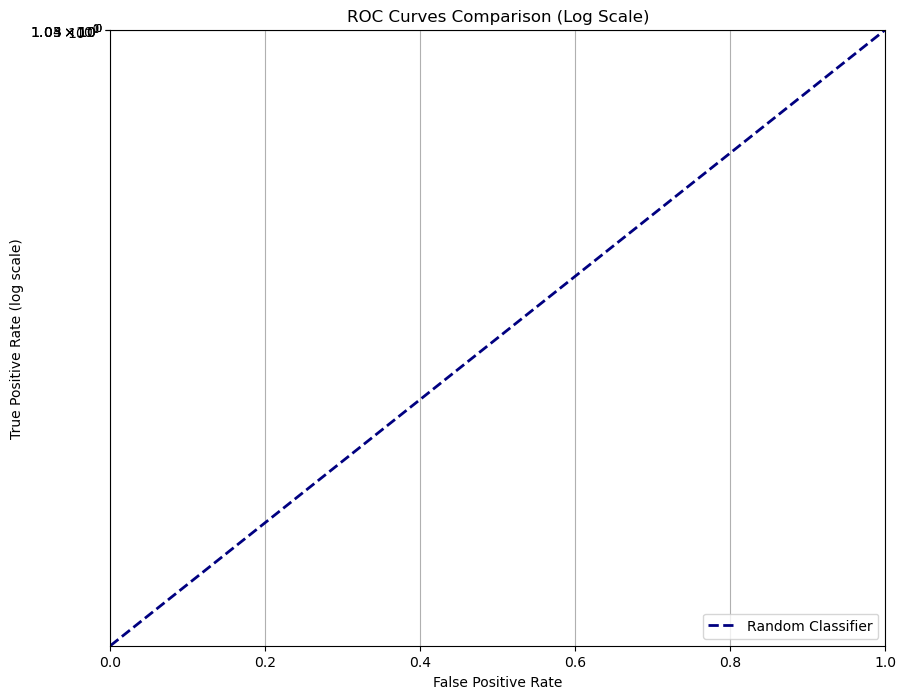

In [67]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import uproot as r
import awkward as ak
from plot_multiple_roc import plot_multiple_roc_curves, get_model_configs, DataFrameDataset

# 1. 加载ROOT文件并处理数据
def read_arrays(file_path):
    """
    从ROOT文件中读取数组
    """
    f = r.open(file_path)
    tree = f["Delphes"]
    
    # 读取喷注特征作为可变长度数组（用零填充）
    jet_pt = ak.fill_none(ak.pad_none(tree["Jet.PT"].array(), 4, axis=1), 0)
    jet_eta = ak.fill_none(ak.pad_none(tree["Jet.Eta"].array(), 4, axis=1), 0)
    jet_phi = ak.fill_none(ak.pad_none(tree["Jet.Phi"].array(), 4, axis=1), 0)
    jet_mass = ak.fill_none(ak.pad_none(tree["Jet.Mass"].array(), 4, axis=1), 0)
    
    # 构建喷注特征的DataFrame
    df = pd.DataFrame({
        "jet_pt1": jet_pt[:, 0],
        "jet_eta1": jet_eta[:, 0],
        "jet_phi1": jet_phi[:, 0],
        "jet_mass1": jet_mass[:, 0],
        "jet_pt2": jet_pt[:, 1],
        "jet_eta2": jet_eta[:, 1],
        "jet_phi2": jet_phi[:, 1],
        "jet_mass2": jet_mass[:, 1],
    })
    
    # 构建其他喷注变量
    df["jet_deta12"] = abs(df["jet_eta1"] - df["jet_eta2"])
    df['jet_dphi12'] = (df['jet_phi1'] - df['jet_phi2']) % (2 * np.pi)  # 限制在[0, 2pi]范围内
    
    # 计算新物理变量
    df['jet_E1'] = np.sqrt(df['jet_pt1']**2 * np.cosh(df['jet_eta1'])**2 + df['jet_mass1']**2)
    df['jet_E2'] = np.sqrt(df['jet_pt2']**2 * np.cosh(df['jet_eta2'])**2 + df['jet_mass2']**2)
    
    # 喷注对不变量质量
    df['jet_inv_mass'] = np.sqrt((df['jet_E1'] + df['jet_E2'])**2 - 
                                (df['jet_pt1']*np.sinh(df['jet_eta1']) + df['jet_pt2']*np.sinh(df['jet_eta2']))**2 - 
                                (df['jet_pt1']*np.cos(df['jet_phi1']) + df['jet_pt2']*np.cos(df['jet_phi2']))**2)
    
    # 角度差
    df['jet_dR12'] = np.sqrt((df['jet_eta1'] - df['jet_eta2'])**2 + 
                            (df['jet_phi1'] - df['jet_phi2'])**2)
    
    # 横向动量不对称性
    df['jet_aT'] = np.abs(df['jet_pt1'] - df['jet_pt2']) / (df['jet_pt1'] + df['jet_pt2'])
    
    return df

# 2. 准备数据
# 定义输入特征列
input_columns = ['jet_pt1', 'jet_eta1', 'jet_phi1', 'jet_mass1', 'jet_pt2', 
                'jet_eta2', 'jet_phi2', 'jet_mass2', 'jet_deta12', 'jet_dphi12',
                'jet_inv_mass', 'jet_dR12', 'jet_aT']

# 加载信号和背景数据
# 注意：您需要根据实际情况修改这些文件路径
signal_df = read_arrays("data/delphes_zprime_1TeV.root")
background_df = read_arrays("data/delphes_multijet.root")

# 添加标签（信号为1，背景为0）
signal_df['label_is_sig'] = 1
background_df['label_is_sig'] = 0

# 合并数据
df = pd.concat([signal_df, background_df], ignore_index=True)

# 分割数据集
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

# 创建测试数据集和数据加载器
test_dataset = DataFrameDataset(test_df, input_columns, 'label_is_sig')
test_loader = DataLoader(test_dataset, batch_size=256, num_workers=4)

# 3. 从tb_logs目录获取模型配置
tb_logs_dir = "iSTEP_2025_SupervisedLearning/ml-tutorial-2025-08-istep/tb_logs/simple_mlp_zprime"
model_configs = get_model_configs(tb_logs_dir)
print(f"找到 {len(model_configs)} 个模型")

# 4. 绘制多个模型的ROC曲线
plot_multiple_roc_curves(model_configs, test_loader)


In [ ]:
path_old = "tb_logs/simple_mlp_zprime/version_4/checkpoints/epoch=49-step=11750.ckpt"

In [ ]:
path_old = "tb_logs/simple_mlp_zprime/version_4/checkpoints/epoch=49-step=11750.ckpt"

In [ ]:
path_old = "tb_logs/simple_mlp_zprime/version_4/checkpoints/epoch=49-step=11750.ckpt"

In [ ]:
path_old = "tb_logs/simple_mlp_zprime/version_4/checkpoints/epoch=49-step=11750.ckpt"

In [ ]:
path_old = "tb_logs/simple_mlp_zprime/version_4/checkpoints/epoch=49-step=11750.ckpt"

In [ ]:
path_old = "tb_logs/simple_mlp_zprime/version_4/checkpoints/epoch=49-step=11750.ckpt"

In [ ]:
path_old = "tb_logs/simple_mlp_zprime/version_4/checkpoints/epoch=49-step=11750.ckpt"